In [1]:
import torch
import torch.nn as nn
import numpy as np
from random import random, randint, shuffle
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# setup matplotlib
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    SAVE_PLOTS = False
else:
    matplotlib.use('Agg')
    SAVE_PLOTS = True
import matplotlib.pyplot as plt


# plt.rcParams['figure.figsize'] = [10, 5]
# plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [3]:
from utils import plot_spikes_in_time, print_and_plot_accuracy_metrics, plot_metrics
from scnn import SNN
from scnn.Spike.readin import ReadInLayer
from scnn.optim import RAdam

# from data.data_augmentor import data_augment # data_augment, batchify, GESTURE_MAPPING
from tools.time_expector import TimeExpector
from tools.notify import notify
time_expector = TimeExpector()

In [4]:
num_of_classes = 2

BATCH_SIZE = 16
IMAGE_SIZE = (10, 10)
FRAMES = 10

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
EPOCHS = 10
NET_STR = 'd(128)'

#====================================== Configs  ======================================
device = torch.device('cpu')# if not torch.cuda.is_available() else 'cuda')
dtype = torch.float
print("Device:", device)

Device: cpu


In [5]:
def train_test_split(x_data, y_data, test_size):
    def _select(data, indices):
        return [data[i] for i in indices]
        
    idx_train = []
    idx_test = []
    for i in range(len(x_data)):
        if random() > test_size:
            idx_train.append(i)
        else:
            idx_test.append(i)

    return _select(x_data, idx_train), _select(x_data, idx_test), _select(y_data, idx_train), _select(y_data, idx_test)


In [6]:
def data_hist(y_data):
    hist = {i:0 for i in range(num_of_classes)}
    for i in y_data:
        hist[i] += 1
    
    max_data = max(hist.values())
    for k, i in hist.items():
        print('%2d)' % k, '#' * int(30 * i / max_data), '(%d)' % i)

In [7]:
def equalizer(data_x, data_y, augmentation_multiplier=0):
    data_y = np.array(data_y)
    data_x = np.array(data_x)
    
    label_indicies = {i: data_y == i for i in range(num_of_classes)}
    label_histogram = {i: sum(label_indicies[i]) for i in range(num_of_classes)}
#     print(label_histogram)
#     print(label_indicies)

    output_x = []
    output_y = []
    
    target_value = max(label_histogram.values()) * (1+augmentation_multiplier)
    for i in range(num_of_classes):
        to_add = target_value - label_histogram[i]
        if not to_add:
            continue
#         print('adding', to_add, 'to', i)
        
        sub_x = data_x[label_indicies[i]]
        sub_y = data_y[label_indicies[i]]
        sub_size = sub_y.shape[0]
        
        for _ in range(to_add):
            rid = randint(0, sub_size-1)
            output_x.append(sub_x[rid])
            output_y.append(sub_y[rid])
    
    for x, y in zip(data_x, data_y):
        output_x.append(x)
        output_y.append(y)
    
    idx = [i for i in range(len(output_x))]
    shuffle(idx)
    output_x = list(np.array(output_x)[idx])
    output_y = list(np.array(output_y)[idx])
    
    return output_x, output_y

In [8]:
import random as rrrnnnddd
x_cache_train = x_cache_test = y_cache_train = y_cache_test = None


def get_img(cond):
    img = np.zeros((FRAMES, 10, 10))
    for f in range(FRAMES):
        for x in range(10):
            for y in range(10):
                if cond(x, y) and  rrrnnnddd.random() < .4:
                    img[f, x,y] = 1
    return img

def load_cache():
    global x_cache_train, x_cache_test, y_cache_train, y_cache_test
    x_cache_data = []
    y_cache_data = []
    
    
    for _ in range(100):
        x_cache_data.append(get_img(lambda x, y: x == y))
        y_cache_data.append(0)
    
    for _ in range(100):
        x_cache_data.append(get_img(lambda x, y: x == 9-y))
        y_cache_data.append(1)
    
    
    x_cache_train, x_cache_test, y_cache_train, y_cache_test = train_test_split(
        x_cache_data,
        y_cache_data,
        test_size=0.3
    )
    
    x_cache_train, y_cache_train = equalizer(x_cache_train, y_cache_train, 2)
    x_cache_test, y_cache_test = equalizer(x_cache_test, y_cache_test)
    

    print('[Done]')
    print('Train Dataset Size: %d * %d' % (len(x_cache_train), BATCH_SIZE))
    print('Test Dataset Size: %d * %d' % (len(x_cache_test), BATCH_SIZE))
    print('--------------------------------------------------\n')
    print('Train Data Histogram:')
    data_hist(y_cache_train)
    print('--------------------------------------------------\n')
    print('Test Data Histogram:')
    data_hist(y_cache_test)
    print('==================================================\n')
    if len(x_cache_test) == 0 or len(x_cache_train) == 0:
        raise Exception('not enough data collected')

0


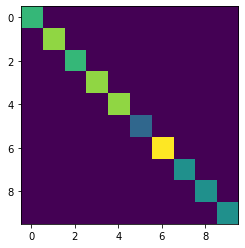

1


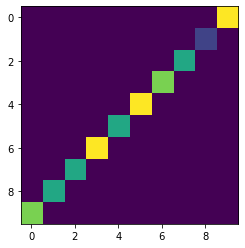

0


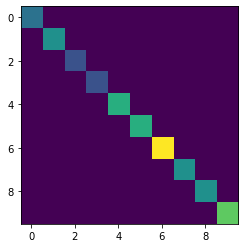

0


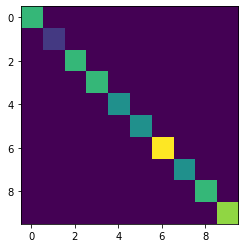

0


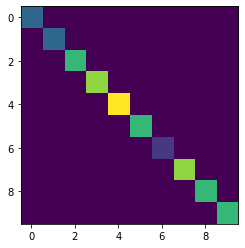

0


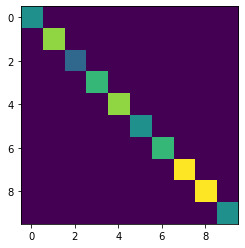

0


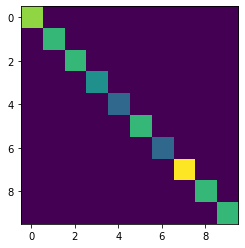

1


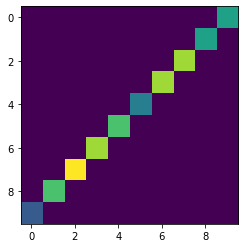

0


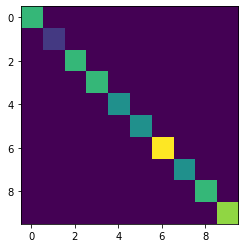

0


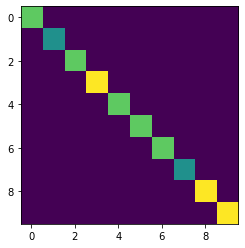

In [16]:
for i in range(10):
    img = np.zeros((10, 10))
    for f in range(10):
        img += x_cache_train[i][f]
    plt.imshow(img)
    print(y_cache_train[i])
    plt.show()

In [9]:
def batchify(data, batch_size):
    x_batch = []
    y_batch = []
    for x_chunk, y_chunk in data:
        if len(x_batch) == batch_size:
            yield x_batch, y_batch
            x_batch = []
            y_batch = []
        x_batch.append(x_chunk)
        y_batch.append(y_chunk)

    
def load_data(trail=''):
    if x_cache_train is None or x_cache_test is None:
        load_cache()
    
    trail = trail.replace('acc_', '')
    zipper = zip(x_cache_train, y_cache_train) if trail == 'train' else zip(x_cache_test, y_cache_test)
    for x_data, y_data in batchify(zipper, BATCH_SIZE):
#         yield np.array(x_data)[:, 0, :, :, :, :], np.array(y_data)[:,0]
        yield np.array(x_data).reshape(BATCH_SIZE, FRAMES, 1, 10, 10), np.array(y_data)

Network Summery:
# | name         | shape       | parameters
0 | ReadinLayer  | (10, 10)x 1 | N/A       
1 | Conv3D       | (10, 10)x 8 | 72        
2 | maxPool2D    | [5, 5]x 8   | N/A       
  |              |             |           
3 | ReadoutLayer | 2           | 400       

[Done]
Train Dataset Size: 402 * 16
Test Dataset Size: 70 * 16
--------------------------------------------------

Train Data Histogram:
 0) ############################## (201)
 1) ############################## (201)
--------------------------------------------------

Test Data Histogram:
 0) ############################## (35)
 1) ############################## (35)

Layer 0: average number of spikes=0.0388
Layer 1: average number of spikes=0.0927


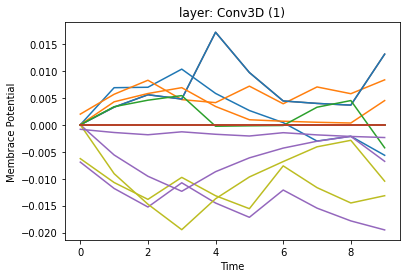

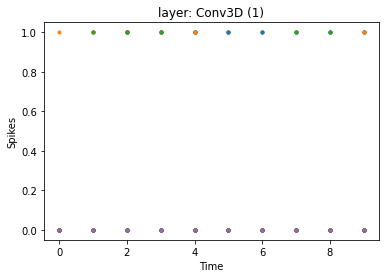

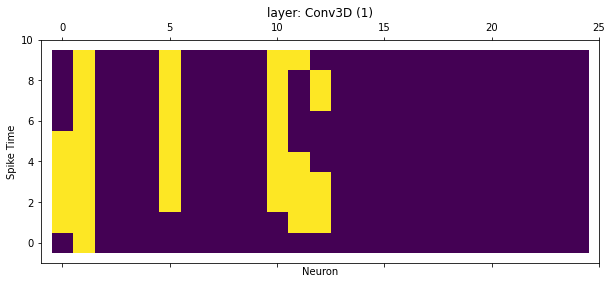

<Figure size 2160x1440 with 0 Axes>

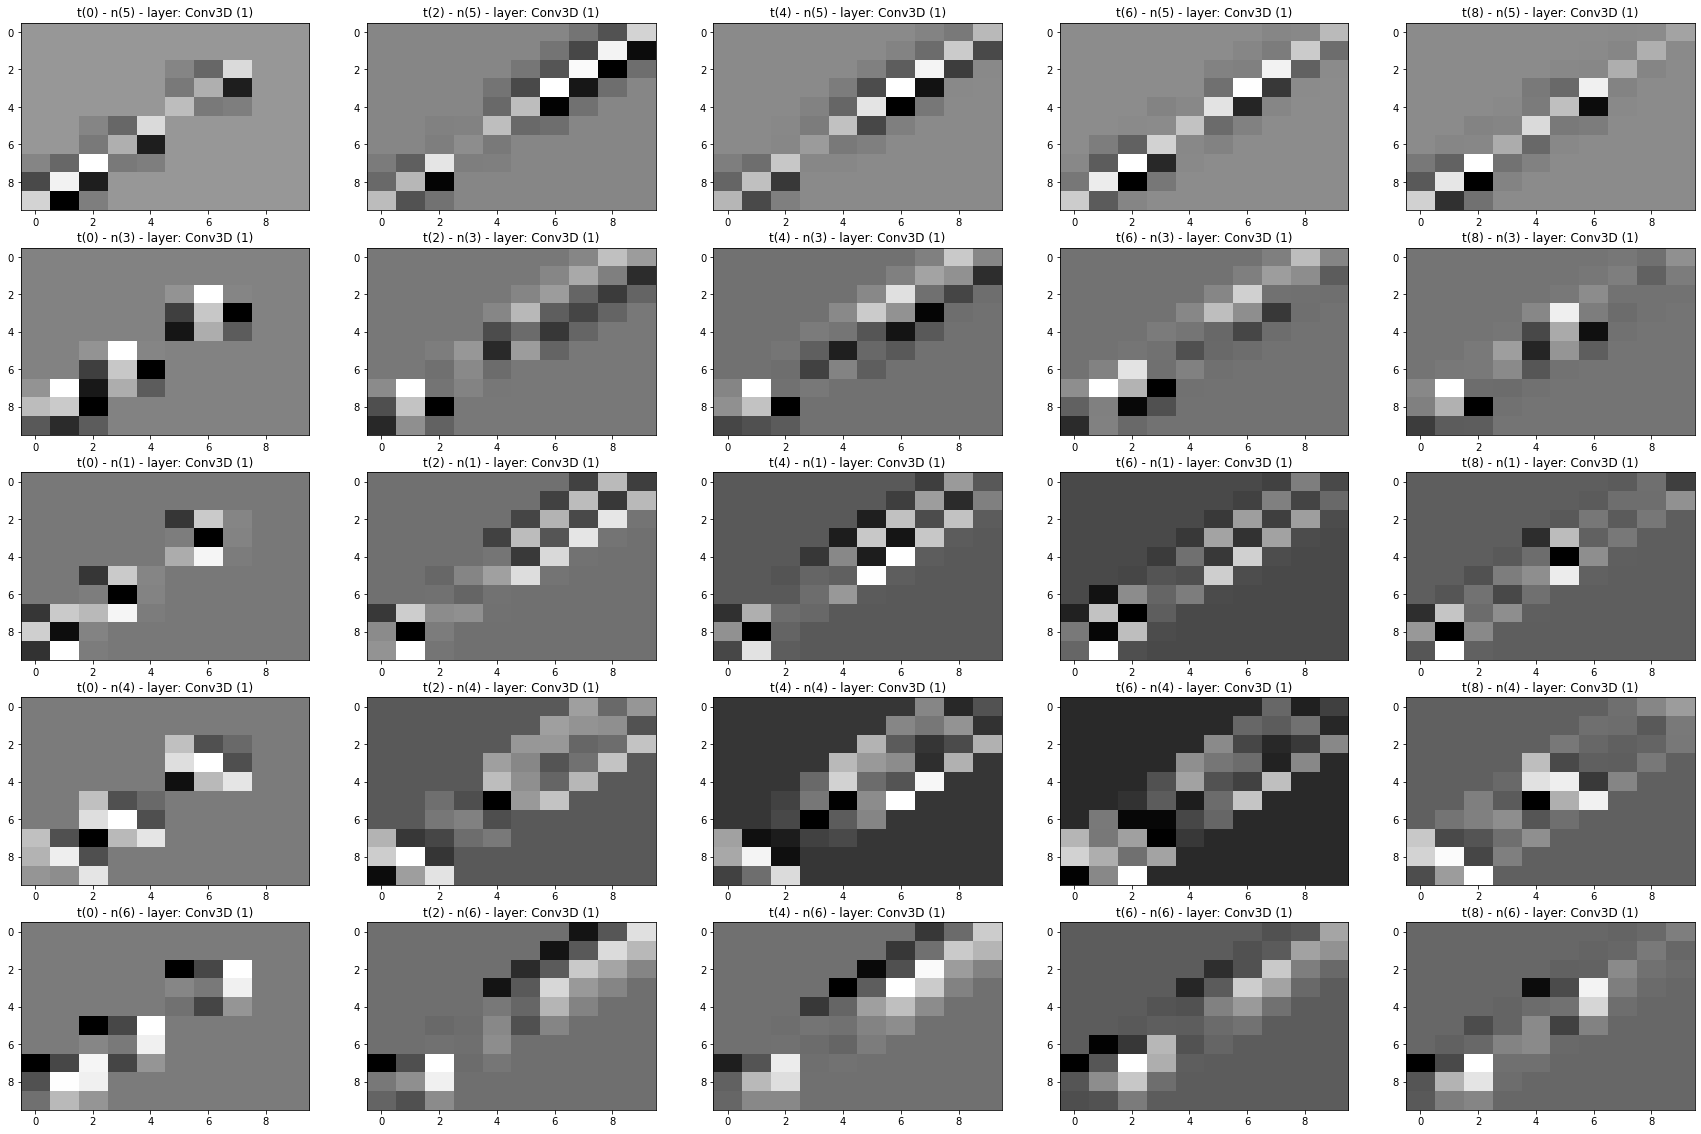

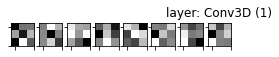

Layer 2: average number of spikes=0.2540


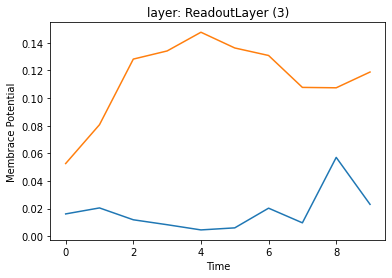

In [11]:
#====================================== Network Begining =====================================
network = SNN(device=device, dtype=dtype)



network.add_conv3d(
    input_shape=(10, 10),
    output_channels=8,
    kernel_size=(1,3,3),
    dilation=(1,1,1),
    lateral_connections=False,
    recurrent=False,
    w_init_mean=0.00,
    w_init_std=0.05
)
network.add_pool2d(kernel_size=(2,2), reduction='max')



# network.add_dense(
#     input_shape=(10, 10),
#     output_shape=20,
    
#     w_init_mean=0.0,
#     w_init_std=0.1,
    
# #     lateral_connections=True,
# #     recurrent=True,
# #     dropout_prob=0.3,
# )


# network.add_dense(
#     output_shape=20,
    
#     w_init_mean=0.0,
#     w_init_std=0.1,
    
# #     lateral_connections=True,
# #     recurrent=False,
# #     dropout_prob=0.3,
# )

#=================================== Network Finalization ====================================
network.add_readout(
    output_shape=num_of_classes,
    time_reduction="max",

    w_init_mean=0.0,
    w_init_std=0.3
)
network.compile()
network.print_summery()
network.plot_one_batch(load_data('train'))

pre-processing dataset: 25
pre-processing dataset: 4
Epoch: 1 [----------------------->....................................]  40%                                   

/home/aref/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch: 1 [===========================================================>] 100%                                   

| Lss.Trn | Lss.Tst | Acc.Trn | Acc.Tst |
|---------|---------|---------|---------|
|  0.0788 |  0.0099 | 100.00% | 100.00% |

Epoch: 2 [===========================================================>] 100%                                   

| Lss.Trn | Lss.Tst | Acc.Trn | Acc.Tst |
|---------|---------|---------|---------|
|  0.0055 |  0.0046 | 100.00% | 100.00% |

Epoch: 3 [===========================================================>] 100%                                   

| Lss.Trn | Lss.Tst | Acc.Trn | Acc.Tst |
|---------|---------|---------|---------|
|  0.0034 |  0.0035 | 100.00% | 100.00% |

Epoch: 4 [===========================================================>] 100%                                   

| Lss.Trn | Lss.Tst | Acc.Trn | Acc.Tst |
|---------|---------|---------|---------|
|  0.0027 |  0.0029 | 100.00% | 100.00% |

Epoch: 5 [==============================

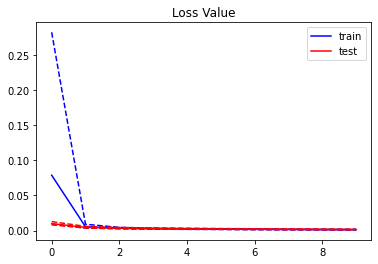

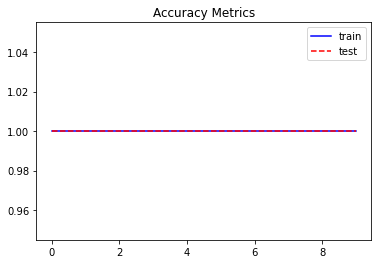

In [12]:
result_file = open('./logs/results.log', 'a+') if SAVE_PLOTS else None
# opt = RAdam(network.get_trainable_parameters(LEARNING_RATE, WEIGHT_DECAY))
opt = torch.optim.SGD(network.get_trainable_parameters(LEARNING_RATE, WEIGHT_DECAY), lr=LEARNING_RATE, momentum=0.9)

res_metrics = network.fit(
    load_data,
    epochs=EPOCHS,
    optimizer=opt,
    result_file=result_file,
    save_checkpoints=False, #SAVE_PLOTS
)
plot_metrics(res_metrics, save_plot_path='./logs/metrics_' if SAVE_PLOTS else None)

if SAVE_PLOTS:
    result_file.close()

In [13]:
# network.save('./logs/save_network.net')
# network.load('./logs/save_network.net')

Layer 0: average number of spikes=0.0404
Layer 1: average number of spikes=0.0973


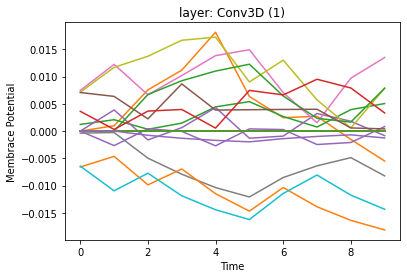

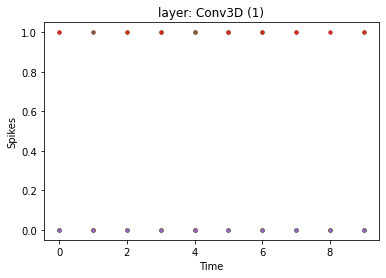

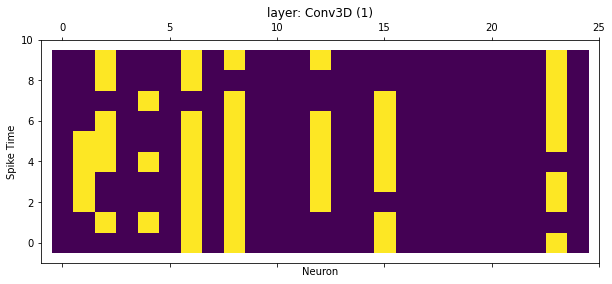

<Figure size 2160x1440 with 0 Axes>

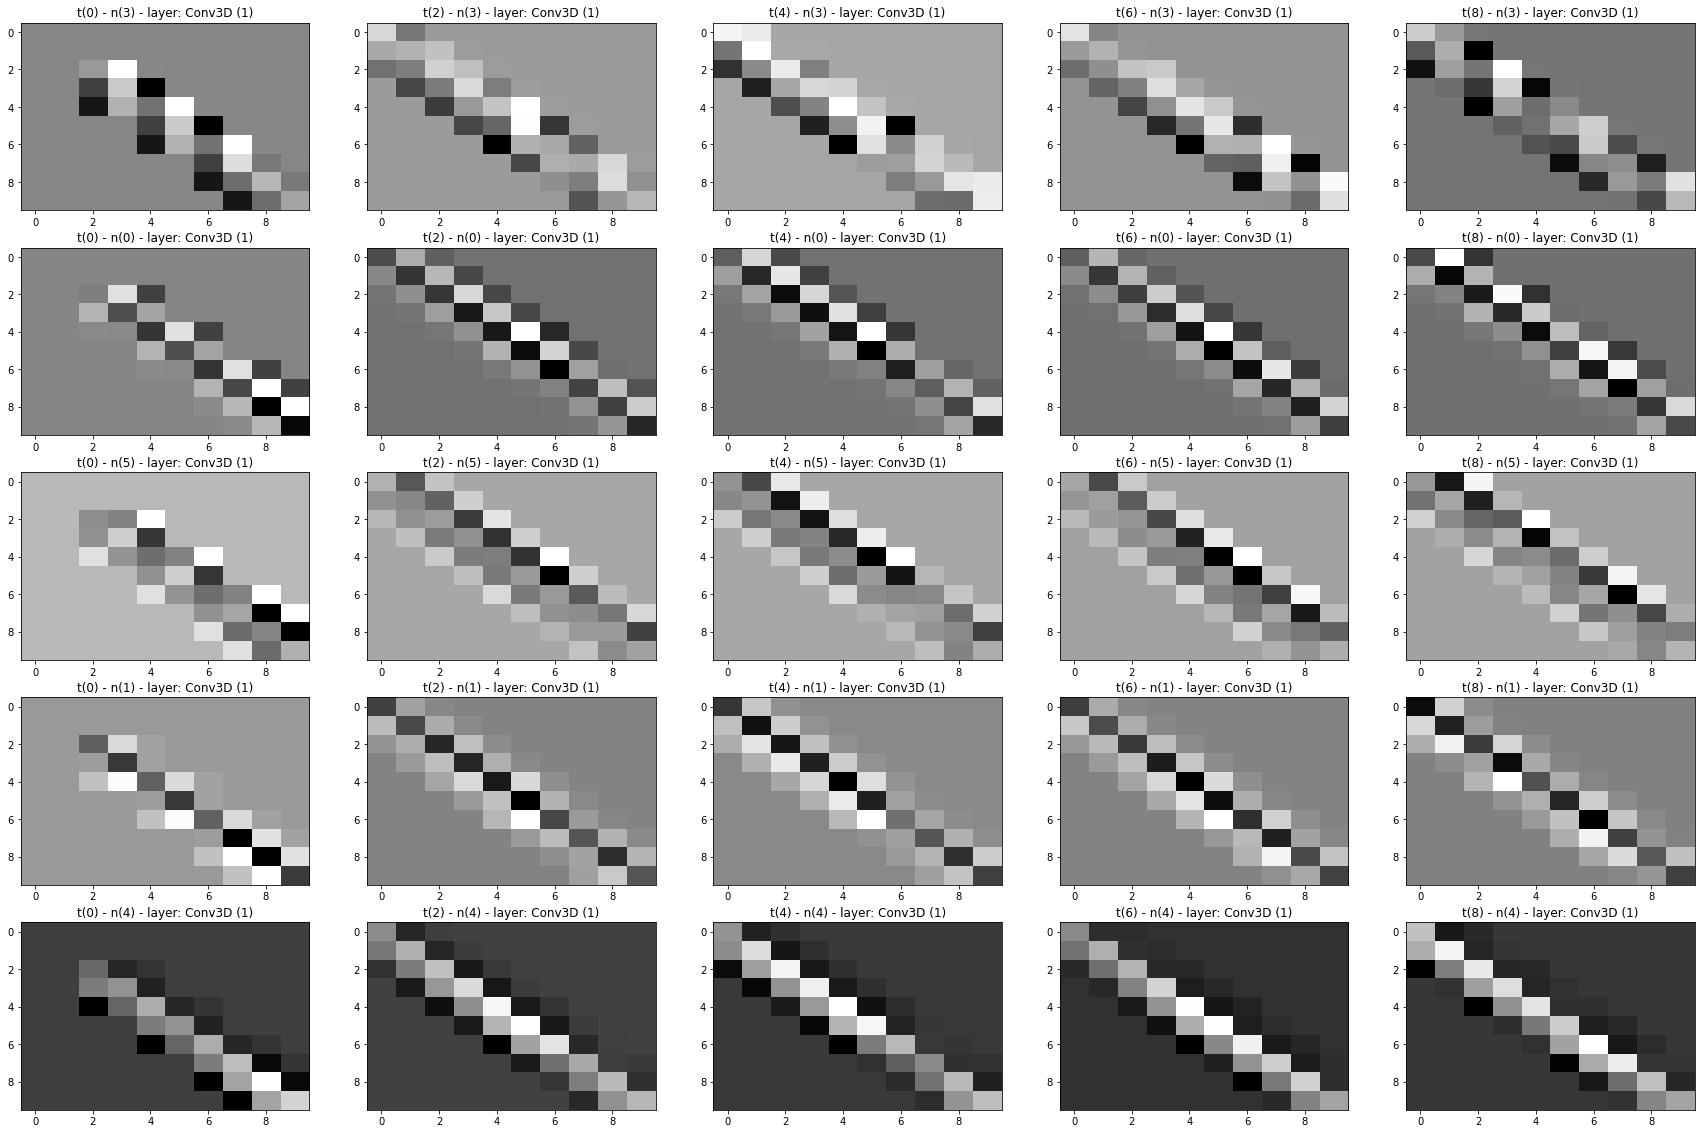

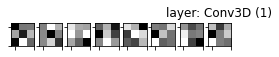

Layer 2: average number of spikes=0.2552


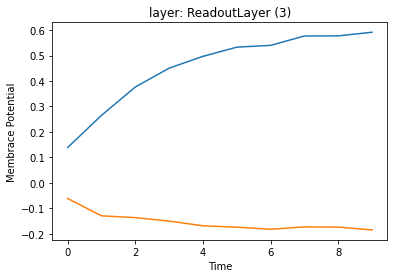


----------------------------------------
Final Train Accuracy=100.00%
Final Test Accuracy=100.00%


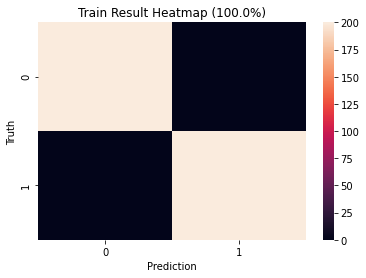

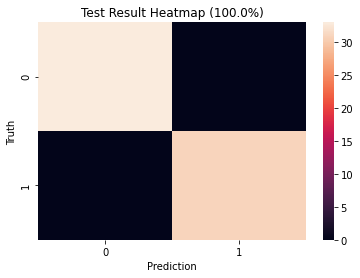

In [14]:
network.plot_one_batch(load_data('test'))
print_and_plot_accuracy_metrics(
    network, 
    load_data('acc_train'), 
    load_data('acc_test'), 
    save_plot_path='./logs/truth_' if SAVE_PLOTS else None
)